# In-Class Group Exercise Review

In [179]:
# Group Review Exercise
import pandas as pd

%matplotlib inline

# Other imports as you see fit (sklearn, etc)

df = pd.read_csv('https://github.com/ga-students/DAT-NYC-37/raw/master/lessons/lesson-11/datasets/titanic.csv')

# Print a basic summary of the data
print df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB
None


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Your objective:

*Given a set of features for a passenger (as defined in the dataset) predict whether or not they will survive on the Titanic.*


1. Perform any necessary conditioning or cleaning to the data
2. Define the train/test split
3. Choose and Define a model with all relevant parameters for that model
4. Fit the model
5. Determine the precision, recall, and F1 score for this model on the *training* dataset
6. Predict whether passengers with the  following features survive:

```
     pclass     sex   age  sibsp  parch    ticket      fare cabin embarked
          3  female   NaN      8      2   CA.2343   69.5500   NaN        S
          3    male   NaN      0      0    349214    7.8958   NaN        S
          3    male   NaN      0      0    349253    7.8958   NaN        C
          1    male  44.0      2      0     19928   90.0000   C78        Q
          2    male  31.0      0      0    244270   13.0000   NaN        S
          1  female  31.0      0      2     36928  164.8667    C7        S
          3  female  38.0      1      5    347077   31.3875   NaN        S
          2    male  30.0      0      0     28228   13.0000   NaN        S
          1    male   NaN      0      0   PC17757  227.5250   NaN        C
          2  female  17.0      0      0    SC1748   12.0000   NaN        C
```

### Tip: use copy the above block and use pd.read_clipboard() to create a dataframe from the contents of your current clipboard

---

# A Possible Solution:

### Step 1: Perform any necessary conditioning or cleaning to the data

In [145]:
##
# Define a function responsible for cleaning the data, so I can reuse it later if need be.
# 
# Cleaning involves three steps for this dataset:
# 1. Transform gender into a boolean type, impute age by replacing NAs with the mean.
# 2. Do dummy encoding for categorical features
def preprocess_data(dataframe):
    
    # 1. Transform gender into a boolean type, impute age by replacing NAs with the mean.
    is_male       = df['sex'].replace({'male': 1, 'female': 0})
    estimated_age = df['age'].fillna(df['age'].mean())
    
    is_male.rename("is_male", inplace=True)
    estimated_age.rename("estimated_age", inplace=True)

    # 2. Do dummy encoding for categorical features
    df_temp = pd.concat([dataframe, is_male, estimated_age], axis=1).drop(['sex', 'age'], axis=1)
    
    return pd.get_dummies(df_temp, columns=['pclass', 'embarked'])

# process_data returns a cleaned version of the original dataframe
df_model = preprocess_data(df)

df_model.head(3)

,survived,name,sibsp,parch,ticket,fare,cabin,is_male,estimated_age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,1,22.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,0,26.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
# Drop columns I don't need for training
X = df_model.drop(['survived', 'name', 'ticket', 'cabin'], axis=1)
y = df_model['survived']  

print "Features:"
X.info();

Features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
sibsp            891 non-null int64
parch            891 non-null int64
fare             891 non-null float64
is_male          891 non-null int64
estimated_age    891 non-null float64
pclass_1         891 non-null float64
pclass_2         891 non-null float64
pclass_3         891 non-null float64
embarked_C       891 non-null float64
embarked_Q       891 non-null float64
embarked_S       891 non-null float64
dtypes: float64(8), int64(3)
memory usage: 76.6 KB


---

### Step 2: Define the Train/Test Split

*We're just using a simple train/test split here. We can later use KFold for more robust modeling and validation later*

In [8]:
from sklearn import tree, cross_validation, linear_model, metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.3, random_state=1
)

---

### Step 3 & 4: Choose and Define a model with all relevant parameters for that model & fit the model

*We'll define a simple function to help us display model results*

In [133]:
# This is just a utility method to help print a summary of the results
def format_model_results(sklearn_model, X_train, X_test, y_train, y_test):
    # Get the model's class name (E.g. LogisticRegression, KNearestNeighbor, etc.) and store it to a string
    model_class_name = sklearn_model.__class__.__name__  
    
    y_test_pred   = sklearn_model.predict(X_test)
    y_test_pred_proba   = sklearn_model.predict_proba(X_test)
    y_train_pred  = sklearn_model.predict(X_train)

    accuracy_score  = metrics.accuracy_score(y_test, y_test_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred)
    recall_score    = metrics.recall_score(y_test, y_test_pred)
    f1_score        = metrics.f1_score(y_test, y_test_pred)
    f1_score_train  = metrics.f1_score(y_train, y_train_pred)
    auc_score       = metrics.roc_auc_score(y_test, y_test_pred_proba[:, 1])
    
    return pd.DataFrame({
            "Accuracy": accuracy_score, 
            "Precision": precision_score, 
            "Recall": recall_score, 
            "F1 score": f1_score, 
            "F1 score (train)": f1_score_train, 
            "AUC": auc_score
        }, index=[model_class_name])

### <span style="color: blue;">Logistic Regression</span>

In [146]:
# Try additional models
logreg_model = linear_model.LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
format_model_results(logreg_model, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
LogisticRegression,0.827167,0.779851,0.720379,0.736111,0.791667,0.66087


### <span style="color: blue;">KNN</span>

In [12]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [136]:
format_model_results(knn_model, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
KNeighborsClassifier,0.730179,0.712687,0.62069,0.781176,0.715909,0.547826


### <span style="color: blue;">Decision Trees</span>

In [150]:
%%timeit
dectree_model = tree.DecisionTreeClassifier()
dectree_model.fit(X_train, y_train)

# - max_depth
# - max_features
# - max_leaf_nodes

1000 loops, best of 3: 1.28 ms per loop


In [137]:
format_model_results(dectree_model, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
DecisionTreeClassifier,0.733731,0.75,0.688372,0.98441,0.74,0.643478


### <span style="color: blue;">Random Forest Classifier</span>

In [171]:
from sklearn.ensemble import RandomForestClassifier

# max_features=None, 
#     oob_score=True, 
#     min_samples_leaf=5
rf_model = RandomForestClassifier(
    n_estimators = 1000,
    oob_score=True, 
    max_features=None
)
rf_model.fit(X_train, y_train)

# TODO
# RF Classifier with 2, 10, 20, 70, 100, 500 n_estimators
#

for n in [2, 10, 20, 70, 100, 500]:
    rf_model = RandomForestClassifier(
        n_estimators = n,
        oob_score=True
    )
    rf_model.fit(X_train, y_train)

    print
    print "n_estimators = %s" % n
    print format_model_results(rf_model, X_train, X_test, y_train, y_test)


n_estimators = 2
                             AUC  Accuracy  F1 score  F1 score (train)  \
RandomForestClassifier  0.769764  0.742537  0.642487          0.899297   

                        Precision   Recall  
RandomForestClassifier   0.794872  0.53913  

n_estimators = 10
                            AUC  Accuracy  F1 score  F1 score (train)  \
RandomForestClassifier  0.84524  0.794776  0.729064          0.961798   

                        Precision    Recall  
RandomForestClassifier   0.840909  0.643478  

n_estimators = 20
                           AUC  Accuracy  F1 score  F1 score (train)  \
RandomForestClassifier  0.8316  0.761194  0.686275          0.980132   

                        Precision    Recall  
RandomForestClassifier   0.786517  0.608696  

n_estimators = 70
                             AUC  Accuracy  F1 score  F1 score (train)  \
RandomForestClassifier  0.838448  0.761194   0.68932          0.984479   

                        Precision    Recall  
RandomForestCla

In [168]:
format_model_results(rf_model, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.837937,0.772388,0.702439,0.98441,0.8,0.626087


## Q: How can we improve F1 score?
  A. Increase size of our training sample using K-fold CV:
    - Train/test split K times with (N_samples/K) samples in our testing set.
    - For each k:
        - Fit the model
        - Calculate the **Result Evaluation Metric** (F1 score/AUC or any other validation metric)
    - Compute the average **Result Evaluation Metric** for all K
    
The above steps are encapsulated in `cross_validation.cross_val_score(model, X, y, cv=n_folds)`:

*Example:*
`cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='roc_auc')`

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html
    

In [177]:
model_rf = RandomForestClassifier(
    n_estimators = 500, 
    max_features=None, 
    oob_score=True, 
    min_samples_leaf=5)

n_folds = 50

##
# `cross_val_score` is a way to train/test split AND compute a score in a single step.
#  It takes three required parameters:
#  1. The model (`model_rf`)
#  2. The dataset (`X`)
#  3. The target ('y')
#
#  Plus a bunch of optional params, but most commonly these will be:
#  - cv (integer): Number of cross-validations (i.e. folds) to perform. This is the same as K
#  - scoring method: e.g. ('roc_auc', 'f1_score')
#   See http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
#
# See: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html
#  - roc_auc
#  - accuracy
#  - f1
cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='roc_auc')

print "Avg AUC Score across %s folds: %s" % (n_folds, cv_score.mean())

Avg AUC Score across 50 folds: 0.884199134199


In [176]:
cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='f1')

print "Avg AUC Score across %s folds: %s" % (n_folds, cv_score.mean())

Avg AUC Score across 50 folds: 0.769381050322


### Interpreting results:

In [131]:
y_test_pred   = rf_model.predict(X_test)

test_results = pd.DataFrame(
    {
        "Predicted survival": y_test_pred,
        "Actual survival": y_test,
        "True Positive": (y_test_pred == y_test) & (y_test_pred == 1),
        "False Positive": (y_test_pred != y_test) & (y_test_pred == 1)
    },
    columns=["Predicted survival", "Actual survival", "True Positive", "False Positive"]
)

true_positives  = (y_test_pred == y_test) & (y_test_pred == 1)
false_positives = (y_test_pred != y_test) & (y_test_pred == 1)
true_negatives  = (y_test_pred == y_test) & (y_test_pred == 0)
false_negatives = (y_test_pred != y_test) & (y_test_pred == 0)

# TODO: Calculate F1-score from above metrics
test_results

,Predicted survival,Actual survival,True Positive,False Positive
862,1,1,True,False
223,0,0,False,False
84,1,1,True,False
680,1,0,False,True
535,1,1,True,False
623,0,0,False,False
148,0,0,False,False
3,1,1,True,False
34,0,0,False,False
241,1,1,True,False


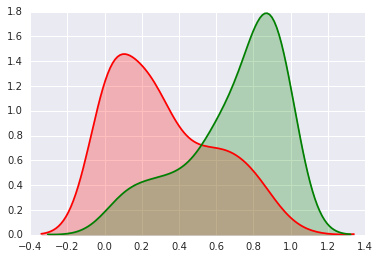

In [180]:
import matplotlib.pyplot as plt

y_test_pred_proba   = rf_model.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_proba[:, 1])

import seaborn as sns

sns.kdeplot(fpr, c="red", shade=True)
sns.kdeplot(tpr, c="green", shade=True);

0.846007388463


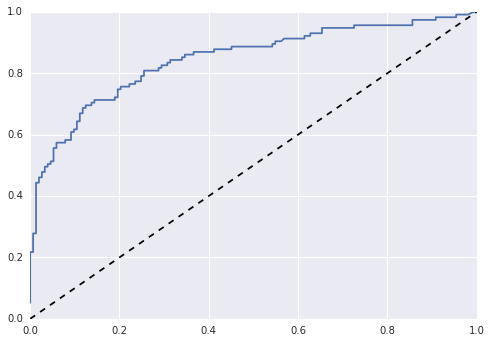

In [126]:
roc_auc = metrics.auc(fpr, tpr)

plt.xlim = [0, 1]
plt.ylim = [0, 1]
ax = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

print metrics.roc_auc_score(y_test, y_test_pred_proba[:, 1])

In [127]:
true_positives  = (y_test_pred == y_test) & (y_test_pred == 1)
false_positives = (y_test_pred != y_test) & (y_test_pred == 1)
true_negatives  = (y_test_pred == y_test) & (y_test_pred == 0)
false_negatives = (y_test_pred != y_test) & (y_test_pred == 0)

num_true_positives = true_positives.sum()
num_false_positives = false_positives.sum()
num_true_negatives = true_negatives.sum()
num_false_negatives = false_negatives.sum()

print float(num_true_positives) / (num_true_positives + num_false_negatives)
print float(num_false_positives) / (num_false_positives + num_true_negatives)

0.6
0.0915032679739


## Comparison

In [141]:
scores_df = pd.concat([
    format_model_results(logreg_model, X_train, X_test, y_train, y_test),
    format_model_results(knn_model, X_train, X_test, y_train, y_test),
    format_model_results(dectree_model, X_train, X_test, y_train, y_test),
    format_model_results(rf_model, X_train, X_test, y_train, y_test),
])

scores_df

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
LogisticRegression,0.827167,0.779851,0.720379,0.736111,0.791667,0.660870
KNeighborsClassifier,0.730179,0.712687,0.620690,0.781176,0.715909,0.547826
DecisionTreeClassifier,0.733731,0.750000,0.688372,0.984410,0.740000,0.643478
RandomForestClassifier,0.846007,0.776119,0.696970,0.840095,0.831325,0.600000


### <span style="color: green; text-decoration: underline;">Note how simple it is to evaluate different models. Most of the work is in cleaning the data!</span>

---

# Solution Part II: Improving the model

Our best model above gives an AUC score of 0.8031. This is a good start, but there are plenty of steps we can take to improve our results:

2. **Feature Engineering:** We may be able to add "synthetic" information to our dataset by adding features from information already present. For instance, we discarded name, but perhaps we could get more information about a passenger by searching for keywords relating to honorifics and titles like 'Sir', 'Miss', 'Mrs', etc. This is called **feature engineering**

1. **Parameter Tuning:** Modifying various parameters of our models may improve performance. For instance, for our RandomForest model we can control the complexity of our model by modifying `num_estimators`, `min_samples_leaf`, `max_features`, etc... *(See: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)*

3. **Improved Cross Validation Techniques:** Because we're holding out 30% of our data for testing, we have less data samples on which to actually build our model. How can we address this?
> **Example:** Use K-Fold cross validation. A larger value of k will allow us to keep more of our data for training, but will require training the same model multiple times.

### Improvement 1: Feature Engineering

In our original analysis we dropped the `cabin`, `ticket`, and `name` columns. However, do these columns contain information that may improve our model?

We can apply our own intelligence to try to add information to the dataset which are not present in the original feature space. We call this *feature engineering*.

In [184]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [142]:
##
# Get first character of values in the cabin column
#    See: http://pandas.pydata.org/pandas-docs/stable/text.html?highlight=string
# 
# Example: get_title("Braund, Mr. Owen Harris")  # -> will return 'mr'
def get_title(name):
    titles = ['miss.','mrs.','master.','mr.','dr.','rev.','sir.','col.','lady.','archibald','major.','capt.']
    
    if name:
        for title in titles:
            if name.lower().find(title.lower()) > -1:
                return title.replace(".", "")

    return "none"

def add_engineered_features(dataframe):
    honorifics         = dataframe['name'].map(get_title)
    cabin_prefixes     = dataframe['cabin'].str.get(0)
    ticket_is_numeric  = dataframe['ticket'].str.isnumeric()
    ticket_starts_with = dataframe['ticket'].str.get(0)

    honorifics.rename('honorific', inplace=True)
    cabin_prefixes.rename('cabin_prefix', inplace=True)
    ticket_is_numeric.rename('ticket_is_numeric', inplace=True)
    ticket_starts_with.rename('ticket_starts_with', inplace=True)

    df_processed = pd.concat([dataframe, honorifics, cabin_prefixes, ticket_is_numeric, ticket_starts_with], axis=1)
    df_processed = pd.get_dummies(df_processed, columns=['honorific', 'cabin_prefix', 'ticket_starts_with'])

    return df_processed.drop(['name', 'cabin', 'ticket'], axis=1)

# Clean the data:
df_model = preprocess_data(df)
df_model_improved = add_engineered_features(df_model)

X = df_model_improved.drop('survived', axis=1)
y = df_model_improved['survived']  

In [185]:
df_model_improved.head()

,survived,sibsp,parch,fare,is_male,estimated_age,pclass_1,pclass_2,pclass_3,embarked_C,...,ticket_starts_with_7,ticket_starts_with_8,ticket_starts_with_9,ticket_starts_with_A,ticket_starts_with_C,ticket_starts_with_F,ticket_starts_with_L,ticket_starts_with_P,ticket_starts_with_S,ticket_starts_with_W
0,0,1,0,7.2500,1,22.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,71.2833,0,38.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0,7.9250,0,26.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,0,53.1000,0,35.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,8.0500,1,35.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Improvements 2 & 3: Evaluating the model with cross-validation and parameter tuning

In [188]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 1000, max_features=None, oob_score=True, min_samples_leaf=5)

n_folds = 100

##
# `cross_val_score` is a way to train/test split AND compute a score in a single step.
#  It takes three required parameters:
#  1. The model (`model_rf`)
#  2. The dataset (`X`)
#  3. The target ('y')
#
#  Plus a bunch of optional params, but most commonly these will be:
#  - cv (integer): Number of cross-validations (i.e. folds) to perform. This is the same as K
#  - scoring method: e.g. ('roc_auc', 'f1_score')
#   See http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
#
# See: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html
cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='roc_auc')

print "Avg AUC Score across %s folds: %s" % (n_folds, cv_score.mean())

model_rf.feature_importances_

KeyboardInterrupt: 

In [144]:
cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='accuracy')

print "Avg Accuracy Score across %s folds: %s" % (n_folds, cv_score.mean())

Avg Accuracy Score across 50 folds: 0.832222222222


## Analyzing the Submissions on Kaggle

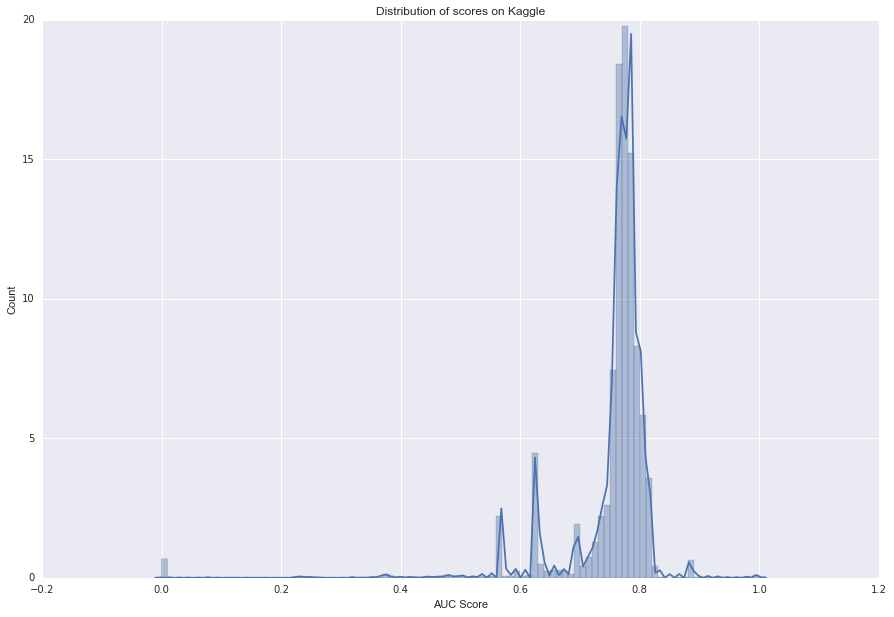

In [187]:
import seaborn as sns

kaggle_scores = pd.read_csv('./titanic_public_leaderboard.csv')

plt.figure(figsize=(15, 10))
ax = sns.distplot(kaggle_scores['Score'], bins=100)

ax.set_title("Distribution of scores on Kaggle")
ax.set_xlabel("AUC Score")
ax.set_ylabel("Count");